# Experiments 5:
### generating byte-to-integers representations derived from file last blocks to train and evaluate our models - FFNN, CNN, GRU, LSTM

In [1]:
import os

import numpy as np
import pandas as pd

from toolkit.utils import get_file_types, get_last_block_bytes, pad_array, convert_cat2num
from toolkit.models import Ffnn, Cnn, Lstm, Gru
from toolkit.metrics import evaluate_performance, plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## 1. Data Preparation

In [2]:
dir_path = 'govdocs1/'
files_data = get_file_types(dir_path)
df = pd.DataFrame(files_data)

In [3]:
df['size KB'] = df['file'].apply(
    lambda x: float(os.path.getsize(
        os.path.join(os.getcwd(), f"govdocs1/{x}")
    ) / 1024.0) if os.path.isfile(
        os.path.join(os.getcwd(), f"govdocs1/{x}")
    ) else None
)

print(f"The average file size is: {df['size KB'].mean()}")

The average file size is: 519.8767892054933


In [4]:
CLASS_NAMES = [
    "doc",
    "pdf",
    "ps",
    "xls",
    "ppt",
    "swf",
    "gif",
    "jpg",
    "png",
    "html",
    "txt",
    "xml"
]

In [5]:
df = df[df['type'].isin(CLASS_NAMES)]
# since the block size is 4 kb on this computer
# we exclude files whose bytes don't fit in the second block 
# this is to avoid including header file bytes in our data
# as we will be using a function that extracts the bytes
# from the last blocks of our files 
df = df[df['size KB'] > 8]
df['type'].value_counts()

type
pdf     174196
html    146731
doc      53250
txt      49990
jpg      46969
xls      46747
ppt      39454
xml      18886
ps       12705
gif      11275
swf       2884
png       1650
Name: count, dtype: int64

In [6]:
# sample the file types we're interested in
df = df.groupby('type').apply(
    lambda x: x if x.name == "png" else x.sample(n=min(len(x), 2000), random_state=42)
).reset_index(drop=True)

df["type"].value_counts()

C:\Users\User\AppData\Local\Temp\ipykernel_27536\603527055.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('type').apply(


type
doc     2000
gif     2000
html    2000
jpg     2000
pdf     2000
ppt     2000
ps      2000
swf     2000
txt     2000
xls     2000
xml     2000
png     1650
Name: count, dtype: int64

In [7]:
base_dir = os.path.join(os.getcwd(), "govdocs1")
df["last_block_bytes"] = df.apply(
    lambda row: get_last_block_bytes(
        path=os.path.join(base_dir, row["file"]), 
        file_size_kb=row["size KB"]
    ), 
    axis=1
)

df["byte_integers"] = df["last_block_bytes"].apply(
    lambda byte_sequence: pad_array(np.array([byte for byte in byte_sequence]))
)

In [8]:
byte_lengths = df["byte_integers"].apply(len)
all_same_length = byte_lengths.nunique() == 1

print("byte lengths of each sequence:\n", byte_lengths)
print("all byte sequences of the same length:", all_same_length)

byte lengths of each sequence:
 0        4096
1        4096
2        4096
3        4096
4        4096
         ... 
23645    4096
23646    4096
23647    4096
23648    4096
23649    4096
Name: byte_integers, Length: 23650, dtype: int64
all byte sequences of the same length: True


In [9]:
df["class"] = df["type"].apply(lambda file_type: convert_cat2num(file_type))
df.sample(n=5)

,file,type,size KB,last_block_bytes,byte_integers,class
11901,499467.ppt,ppt,3137.500000,b'\x1f\x00\x1b\x00\x04\x00\x00\x00.\x01\x01\x0...,"[31, 0, 27, 0, 4, 0, 0, 0, 46, 1, 1, 0, 4, 0, ...",5
12069,466528.ppt,ppt,5785.500000,b'\xfd\xff\xff\xff\xfd\xff\xff\xff\xfd\xff\xff...,"[253, 255, 255, 255, 253, 255, 255, 255, 253, ...",5
3608,226960.gif,gif,19.200195,b'\xf5Z\xefr\x81\xab\xb9\x9c\xcf\xf9\xc2\xa6\x...,"[245, 90, 239, 114, 129, 171, 185, 156, 207, 2...",7
9949,412962.pdf,pdf,92.354492,b'062606 00000 n \n0000062628 00000 n \n000006...,"[48, 54, 50, 54, 48, 54, 32, 48, 48, 48, 48, 4...",2
17894,210109.txt,txt,962.885742,b'967\r\n44162\t-0.28\t927.5\t756\r\n44163\t-0...,"[57, 54, 55, 13, 10, 52, 52, 49, 54, 50, 9, 45...",11


In [10]:
X = np.array([x for x in df["byte_integers"]])
y = np.array([y for y in df["class"]])

In [11]:
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (23650, 4096)
y shape:  (23650,)


In [12]:
# 70% train
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# 15% validation and 15% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## 2. Models Training and Evaluation

### Feed Forward Neural Network

In [14]:
ffnn = Ffnn(timesteps=4096, features=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4096, 256)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │     6,815,757 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,849,165 (26.13 MB)

 Trainable params: 6,849,165 (26.13 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
ffnn.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=4,
    batch_size=32
)

Epoch 1/4
518/518 ━━━━━━━━━━━━━━━━━━━━ 159s 305ms/step - accuracy: 0.2310 - loss: 172.1015 - val_accuracy: 0.3589 - val_loss: 1.9704
Epoch 2/4
518/518 ━━━━━━━━━━━━━━━━━━━━ 159s 306ms/step - accuracy: 0.4441 - loss: 1.8041 - val_accuracy: 0.3908 - val_loss: 1.7672
Epoch 3/4
518/518 ━━━━━━━━━━━━━━━━━━━━ 159s 307ms/step - accuracy: 0.4983 - loss: 1.5423 - val_accuracy: 0.3882 - val_loss: 1.7123
Epoch 4/4
518/518 ━━━━━━━━━━━━━━━━━━━━ 159s 308ms/step - accuracy: 0.5255 - loss: 1.3872 - val_accuracy: 0.3964 - val_loss: 1.6904


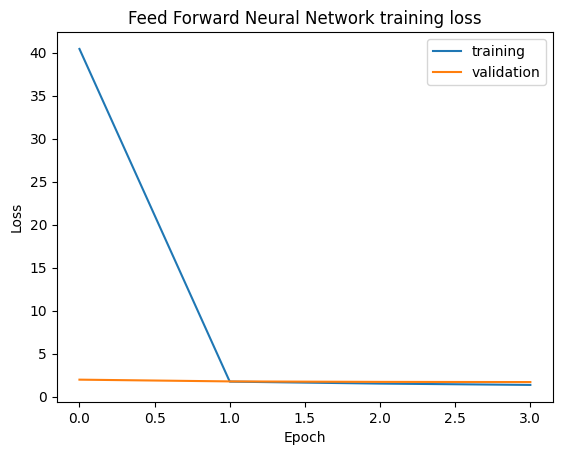

In [16]:
ffnn.plot_learning_curves()

In [17]:
ffnn_pred = ffnn.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step


In [18]:
metrics = evaluate_performance(y_test, ffnn_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{ffnn.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Feed Forward Neural Network performance evaluation:

accuracy	0.39571589627959414.
precision	0.3867950128425131.
recall		0.3999961000724173.
f1-score	0.3474188032093912.


c:\Users\User\Desktop\MSC\S1\DISSERTATION\code\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
ffnn_report = classification_report(y_test, ffnn_pred, target_names=CLASS_NAMES)
print(ffnn_report)

              precision    recall  f1-score   support

         doc       0.85      0.76      0.80       280
         pdf       0.11      0.01      0.03       335
          ps       0.54      0.02      0.04       311
         xls       0.80      0.81      0.80       288
         ppt       0.76      0.83      0.79       337
         swf       0.34      0.29      0.31       283
         gif       0.35      0.41      0.38       301
         jpg       0.30      0.30      0.30       276
         png       0.41      0.37      0.39       260
        html       0.00      0.00      0.00       292
         txt       0.00      0.00      0.00       301
         xml       0.19      0.99      0.32       284

    accuracy                           0.40      3548
   macro avg       0.39      0.40      0.35      3548
weighted avg       0.39      0.40      0.34      3548



c:\Users\User\Desktop\MSC\S1\DISSERTATION\code\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\Desktop\MSC\S1\DISSERTATION\code\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\Desktop\MSC\S1\DISSERTATION\code\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

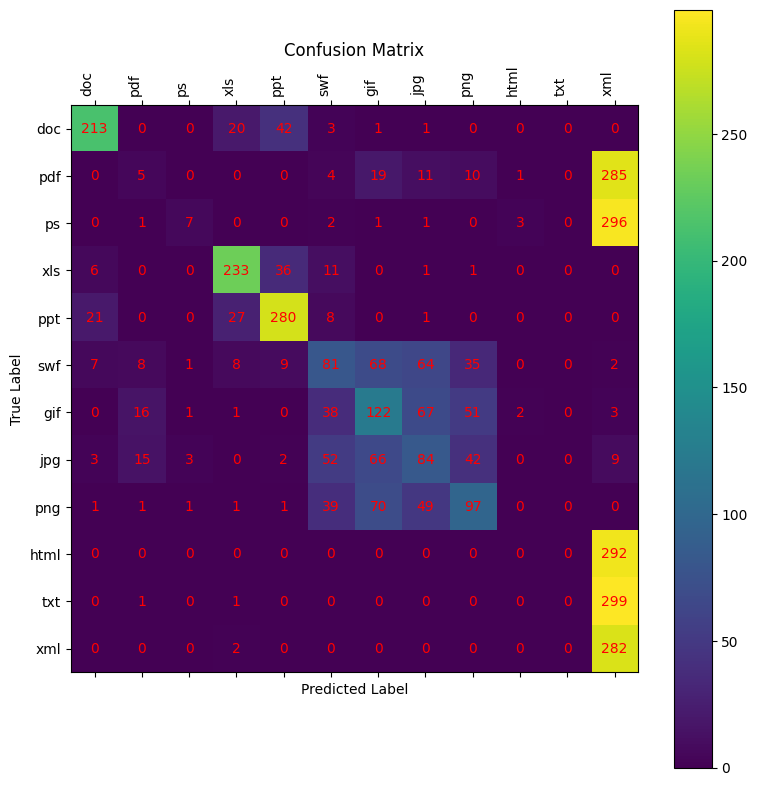

In [20]:
ffnn_cm = confusion_matrix(y_test, ffnn_pred)
plot_confusion_matrix(ffnn_cm, CLASS_NAMES)

### Convolutional Neural Network

In [21]:
cnn = Cnn(timesteps=4096, features=1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4094, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2047, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2045, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1022, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 130816)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │     1,700,621 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,725,581 (6.58 MB)

 Trainable params: 1,725,581 (6.58 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
cnn.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=4,
    batch_size=32
)

Epoch 1/4
518/518 ━━━━━━━━━━━━━━━━━━━━ 78s 148ms/step - accuracy: 0.3243 - loss: 60.8849 - val_accuracy: 0.4243 - val_loss: 1.6614
Epoch 2/4
518/518 ━━━━━━━━━━━━━━━━━━━━ 76s 147ms/step - accuracy: 0.5372 - loss: 1.3564 - val_accuracy: 0.4649 - val_loss: 1.6133
Epoch 3/4
518/518 ━━━━━━━━━━━━━━━━━━━━ 76s 147ms/step - accuracy: 0.6704 - loss: 1.0166 - val_accuracy: 0.5018 - val_loss: 1.7207
Epoch 4/4
518/518 ━━━━━━━━━━━━━━━━━━━━ 76s 147ms/step - accuracy: 0.7679 - loss: 0.7187 - val_accuracy: 0.5250 - val_loss: 2.0103


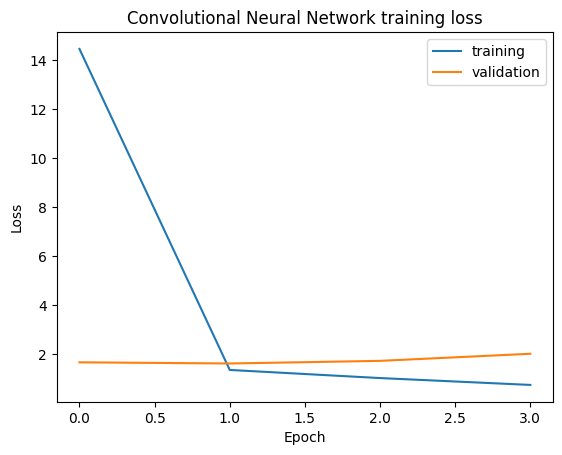

In [23]:
cnn.plot_learning_curves()

In [24]:
cnn_pred = cnn.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step


In [25]:
metrics = evaluate_performance(y_test, cnn_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{cnn.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Convolutional Neural Network performance evaluation:

accuracy	0.5326944757609922.
precision	0.5168011473462623.
recall		0.5226449316112173.
f1-score	0.5095800856137181.


In [26]:
cnn_report = classification_report(y_test, cnn_pred, target_names=CLASS_NAMES)
print(cnn_report)

              precision    recall  f1-score   support

         doc       0.90      0.81      0.85       280
         pdf       0.69      0.79      0.74       335
          ps       0.46      0.77      0.58       311
         xls       0.75      0.89      0.81       288
         ppt       0.82      0.82      0.82       337
         swf       0.38      0.34      0.36       283
         gif       0.41      0.15      0.22       301
         jpg       0.25      0.28      0.26       276
         png       0.28      0.22      0.25       260
        html       0.43      0.36      0.39       292
         txt       0.41      0.39      0.40       301
         xml       0.42      0.47      0.44       284

    accuracy                           0.53      3548
   macro avg       0.52      0.52      0.51      3548
weighted avg       0.52      0.53      0.52      3548



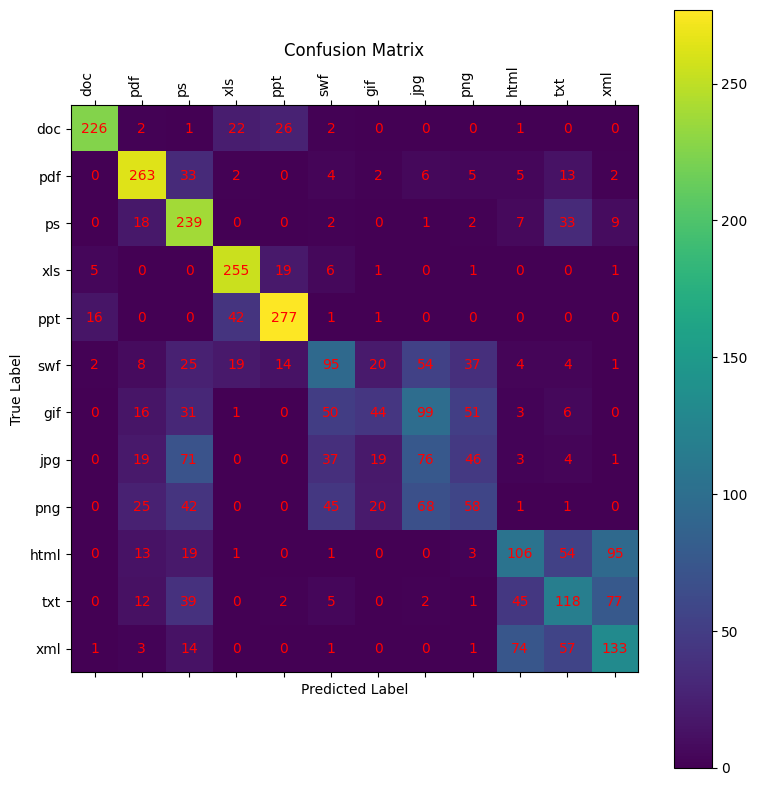

In [27]:
cnn_cm = confusion_matrix(y_test, cnn_pred)
plot_confusion_matrix(cnn_cm, CLASS_NAMES)

### Gated Reccurent Unit

In [28]:
gru = Gru(timesteps=4096, features=1)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 136)            │        28,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 13)             │         1,781 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,749 (120.11 KB)

 Trainable params: 30,749 (120.11 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
gru.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 1372s 3s/step - accuracy: 0.4577 - loss: 1.5136 - val_accuracy: 0.7037 - val_loss: 0.6931
Epoch 2/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 1467s 3s/step - accuracy: 0.7577 - loss: 0.6166 - val_accuracy: 0.8055 - val_loss: 0.5034
Epoch 3/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 1752s 3s/step - accuracy: 0.8133 - loss: 0.4696 - val_accuracy: 0.8241 - val_loss: 0.4302
Epoch 4/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 2530s 5s/step - accuracy: 0.8415 - loss: 0.4026 - val_accuracy: 0.8204 - val_loss: 0.4213
Epoch 5/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 1850s 4s/step - accuracy: 0.8497 - loss: 0.4016 - val_accuracy: 0.7474 - val_loss: 0.6599
Epoch 6/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 1618s 3s/step - accuracy: 0.7979 - loss: 0.5633 - val_accuracy: 0.7375 - val_loss: 0.7394
Epoch 7/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 1583s 3s/step - accuracy: 0.8309 - loss: 0.5021 - val_accuracy: 0.8506 - val_loss: 0.4340
Epoch 8/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 1602s 3s/step - accuracy: 0.8701 - loss: 0.3881 - 

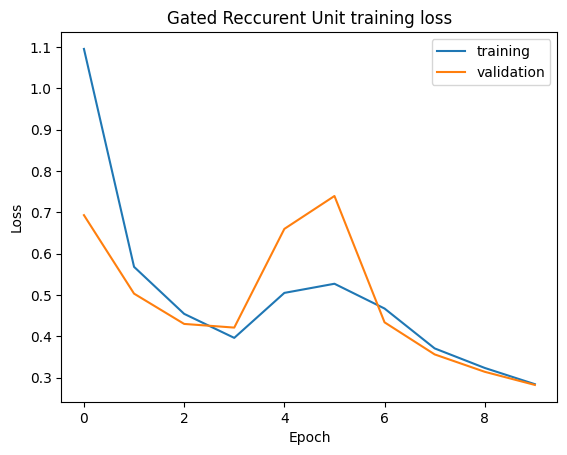

In [30]:
gru.plot_learning_curves()

In [31]:
gru_pred = gru.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 61s 542ms/step


In [32]:
metrics = evaluate_performance(y_test, gru_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{gru.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Gated Reccurent Unit performance evaluation:

accuracy	0.9036076662908681.
precision	0.9048275983748896.
recall		0.9027029483327121.
f1-score	0.9020788126725039.


In [33]:
gru_report = classification_report(y_test, gru_pred, target_names=CLASS_NAMES)
print(gru_report)

              precision    recall  f1-score   support

         doc       0.80      0.92      0.85       280
         pdf       0.98      0.96      0.97       335
          ps       0.95      0.92      0.94       311
         xls       0.88      0.78      0.83       288
         ppt       0.95      0.92      0.93       337
         swf       0.88      0.77      0.82       283
         gif       0.98      0.98      0.98       301
         jpg       0.77      0.88      0.82       276
         png       0.99      1.00      1.00       260
        html       0.90      0.82      0.86       292
         txt       0.86      0.96      0.90       301
         xml       0.91      0.93      0.92       284

    accuracy                           0.90      3548
   macro avg       0.90      0.90      0.90      3548
weighted avg       0.91      0.90      0.90      3548



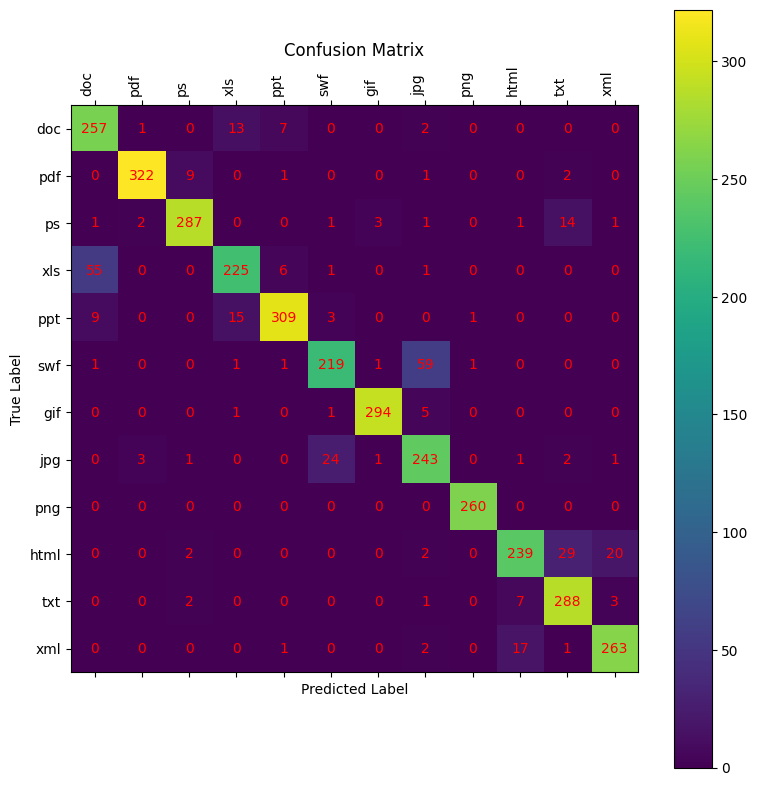

In [34]:
gru_cm = confusion_matrix(y_test, gru_pred)
plot_confusion_matrix(gru_cm, CLASS_NAMES)

### Long Short-Term Memory

In [35]:
lstm = Lstm(timesteps=4096, features=1)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 136)            │        38,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 13)             │         1,781 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,861 (155.71 KB)

 Trainable params: 39,861 (155.71 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
lstm.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 1650s 3s/step - accuracy: 0.3373 - loss: 1.8501 - val_accuracy: 0.5898 - val_loss: 1.1607
Epoch 2/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 2527s 5s/step - accuracy: 0.6027 - loss: 1.1109 - val_accuracy: 0.6851 - val_loss: 0.8423
Epoch 3/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 1520s 3s/step - accuracy: 0.6910 - loss: 0.8065 - val_accuracy: 0.6981 - val_loss: 0.7285
Epoch 4/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 1700s 3s/step - accuracy: 0.6997 - loss: 0.7089 - val_accuracy: 0.7260 - val_loss: 0.6752
Epoch 5/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 1701s 3s/step - accuracy: 0.7317 - loss: 0.6467 - val_accuracy: 0.7364 - val_loss: 0.6233
Epoch 6/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 1553s 3s/step - accuracy: 0.7444 - loss: 0.6202 - val_accuracy: 0.7773 - val_loss: 0.5607
Epoch 7/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 1567s 3s/step - accuracy: 0.7955 - loss: 0.5293 - val_accuracy: 0.8001 - val_loss: 0.5001
Epoch 8/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 1618s 3s/step - accuracy: 0.8122 - loss: 0.4808 - 

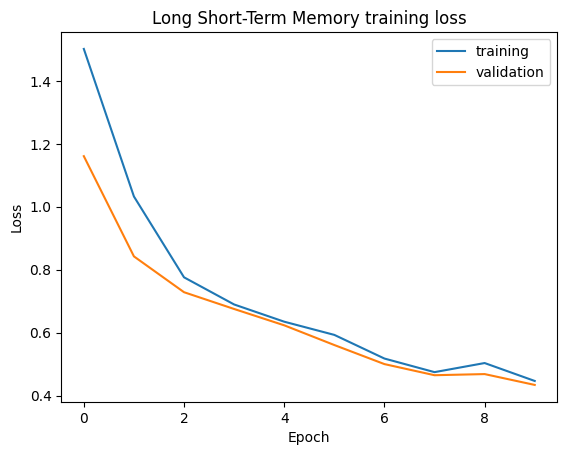

In [37]:
lstm.plot_learning_curves()

In [38]:
lstm_pred = lstm.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 101s 904ms/step


In [39]:
metrics = evaluate_performance(y_test, lstm_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{lstm.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Long Short-Term Memory performance evaluation:

accuracy	0.8351183765501691.
precision	0.8440579325162312.
recall		0.835858895061719.
f1-score	0.8367588116749561.


In [40]:
lstm_report = classification_report(y_test, lstm_pred, target_names=CLASS_NAMES)
print(lstm_report)

              precision    recall  f1-score   support

         doc       0.60      0.77      0.68       280
         pdf       0.96      0.98      0.97       335
          ps       0.98      0.90      0.93       311
         xls       0.89      0.67      0.76       288
         ppt       0.67      0.65      0.66       337
         swf       0.87      0.86      0.87       283
         gif       0.97      0.96      0.97       301
         jpg       0.85      0.89      0.87       276
         png       0.98      0.99      0.99       260
        html       0.67      0.81      0.73       292
         txt       0.92      0.87      0.89       301
         xml       0.77      0.67      0.72       284

    accuracy                           0.84      3548
   macro avg       0.84      0.84      0.84      3548
weighted avg       0.84      0.84      0.84      3548



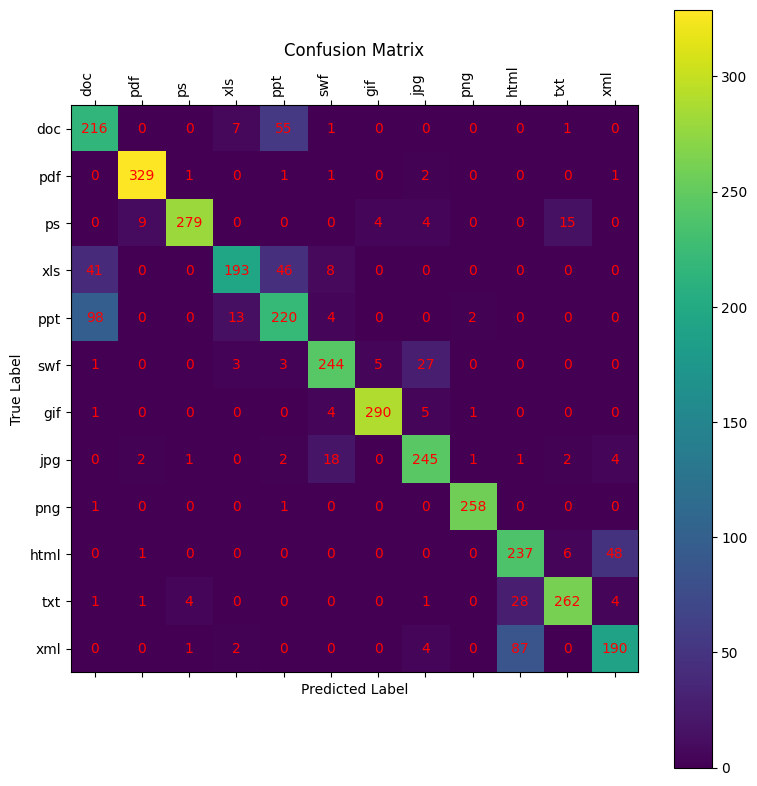

In [41]:
lstm_cm = confusion_matrix(y_test, lstm_pred)
plot_confusion_matrix(lstm_cm, CLASS_NAMES)